<a href="https://colab.research.google.com/github/Cnaraa/websiteClassification/blob/main/Website_Classification_RU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip uninstall numpy -y
#!pip install numpy==1.26.0
#!pip install gensim

In [22]:
import pandas as pd
import numpy as np
import ast

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

file_path = "/content/drive/MyDrive/Website Classification/final_dataset.csv"
df = pd.read_csv(file_path)

In [23]:
print(df.shape)
print("-" * 20)
df.head()

(140049, 4)
--------------------


,preprocessed_translated_title,preprocessed_translated_summary,text,main_label
0,представительство функциональность натуралисти...,статья анализироваться основополагающие принци...,представительство функциональность натуралисти...,Искусственный интеллект и машинное обучение
1,neurochat нейродорожный ai chatbot адаптация у...,время электроэнцефалические эег нейроадаптивны...,neurochat нейродорожный ai chatbot адаптация у...,Искусственный интеллект и машинное обучение
2,денонсация гамильтонский сеть физический обосн...,система машинный обучение физический проблема ...,денонсация гамильтонский сеть физический обосн...,Искусственный интеллект и машинное обучение
3,снимок фильтр генерировать инструкция выбор пр...,визуальный инструктирование vit модель больший...,снимок фильтр генерировать инструкция выбор пр...,Искусственный интеллект и машинное обучение
4,модель большой видение лангуажа совпадать боль...,эффективный понимание помощь язык зрение крупн...,модель большой видение лангуажа совпадать боль...,Искусственный интеллект и машинное обучение


In [24]:
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

In [25]:
df.head()

,preprocessed_translated_title,preprocessed_translated_summary,text,main_label
0,записка заказной график русс шемереди,недавний прорыв работа behnezhad ghafi foss по...,записка заказной график русс шемереди недавний...,Фундаментальные основы CS
1,новый система небиинарного реагирование физиче...,физический неклонируемые функция пуф широко ис...,новый система небиинарного реагирование физиче...,Криптография и безопасность
2,локализация основа вай фи использование нервно...,связь продолжающимся развитие служба основа оп...,локализация основа вай фи использование нервно...,Распределённые и параллельные вычисления
3,преобразование предварительно подготовить моде...,вместе отличие дорогостоящий профессиональный ...,преобразование предварительно подготовить моде...,Искусственный интеллект и машинное обучение
4,практический обнаруживаемость устойчивый струк...,устойчивый память тч представлять новый класс ...,практический обнаруживаемость устойчивый струк...,Распределённые и параллельные вычисления


In [26]:
X_texts = df['text'].tolist()
y_labels = df['main_label'].values

In [27]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

In [28]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_texts)

X_seq = tokenizer.texts_to_sequences(X_texts)
X_pad = pad_sequences(X_seq, maxlen=128, padding='post', truncating='post')

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        query, key, value = inputs, inputs, inputs
        score = tf.matmul(query, key, transpose_b=True)
        weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(weights, value)
        return context

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

In [31]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [32]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, gamma=2., alpha=0.25, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)

        focal_factor = tf.math.pow(1 - y_pred, self.gamma)
        loss = self.alpha * focal_factor * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

In [33]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import GlorotUniform


focal_loss = FocalLoss(gamma=2., alpha=0.25)


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_query = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer=GlorotUniform(),
            trainable=True,
            name="W_query"
        )
        self.W_key = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer=GlorotUniform(),
            trainable=True,
            name="W_key"
        )
        self.W_value = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer=GlorotUniform(),
            trainable=True,
            name="W_value"
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        query = tf.matmul(inputs, self.W_query)
        key = tf.matmul(inputs, self.W_key)
        value = tf.matmul(inputs, self.W_value)

        score = tf.matmul(query, key, transpose_b=True)
        weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(weights, value)
        return context

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling1D, Concatenate, Input
from tensorflow.keras.optimizers import Adam

In [37]:
input_layer = Input(shape=(128,))
embedding = Embedding(input_dim=20000, output_dim=128)(input_layer)
bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)

attention_output = AttentionLayer()(bi_lstm)
pooling_avg = GlobalAveragePooling1D()(attention_output)
pooling_max = GlobalMaxPooling1D()(attention_output)
pooling = Concatenate()([pooling_avg, pooling_max])
dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(pooling)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(len(le.classes_), activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=FocalLoss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 128, 128)  │  2,560,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 128, 256)  │    263,168 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_4   │ (None, 128, 256)  │    196,608 │ bidirectional_4[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_layer_… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention_layer_… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │      2,570 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,153,674 (12.03 MB)

 Trainable params: 3,153,674 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=2)

In [39]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1845s 1s/step - accuracy: 0.5368 - loss: 0.2991 - val_accuracy: 0.6704 - val_loss: 0.1328 - learning_rate: 5.0000e-04
Epoch 2/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1833s 1s/step - accuracy: 0.6886 - loss: 0.1202 - val_accuracy: 0.6829 - val_loss: 0.1240 - learning_rate: 5.0000e-04
Epoch 3/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1787s 1s/step - accuracy: 0.7185 - loss: 0.0985 - val_accuracy: 0.6830 - val_loss: 0.1236 - learning_rate: 5.0000e-04
Epoch 4/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1814s 1s/step - accuracy: 0.7432 - loss: 0.0813 - val_accuracy: 0.6753 - val_loss: 0.1296 - learning_rate: 5.0000e-04
Epoch 5/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1783s 1s/step - accuracy: 0.7664 - loss: 0.0675 - val_accuracy: 0.6719 - val_loss: 0.1405 - learning_rate: 5.0000e-04
Epoch 6/10
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1828s 1s/step - accuracy: 0.8029 - loss: 0.0500 - val_accuracy: 0.6697 - val_loss: 0.1583 - learning_rate: 2.5000e-04
Epoch 7/10
1751/1751 ━━━━━━━━━━━━━━━━━━━

In [40]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

876/876 ━━━━━━━━━━━━━━━━━━━━ 162s 185ms/step - accuracy: 0.6801 - loss: 0.1250
Test accuracy: 0.6830


In [43]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

876/876 ━━━━━━━━━━━━━━━━━━━━ 180s 205ms/step
                                             precision    recall  f1-score   support

                       Информационный поиск       0.51      0.21      0.30       805
Искусственный интеллект и машинное обучение       0.70      0.73      0.71     10839
Компьютерное зрение и распознавание образов       0.53      0.63      0.58      1788
                      Компьютеры и общество       0.64      0.49      0.56      1565
                Криптография и безопасность       0.63      0.67      0.65      1445
              Обработка естественного языка       0.68      0.73      0.71      3520
   Распределённые и параллельные вычисления       0.63      0.61      0.62      1568
                              Робототехника       0.70      0.67      0.68      1500
                  Фундаментальные основы CS       0.81      0.80      0.80      3895
       Человеко-компьютерное взаимодействие       0.61      0.50      0.55      1085

                  

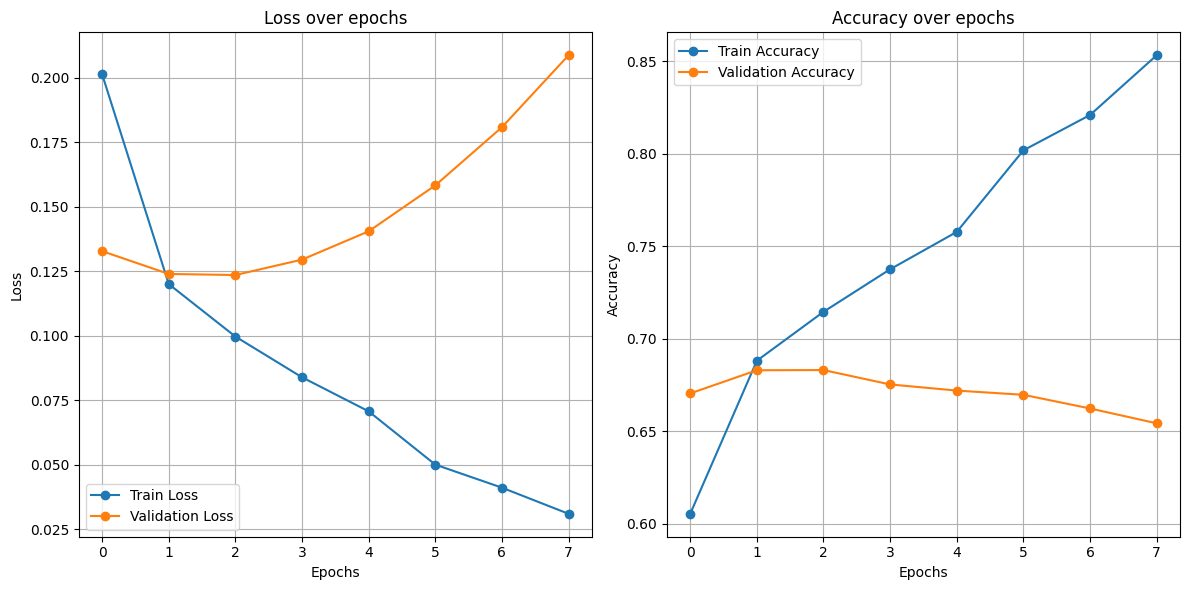

In [47]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
import pickle

In [51]:
model.save('text_classification_model.keras')

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [52]:
from google.colab import files
files.download('text_classification_model.keras')
files.download('tokenizer.pkl')
files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>